# Song Generation: Neural Style Transfer for audio

With the use of convolutional neural networks (CNNs), we saw a vast rise in works involving style transfer to create a new image involving the content from one image and the style from a different image. In this project, we will be investigating applications and usage of CNNs in generating audios from random noise containing the content (i.e. tempo, melody) of one audio clip and the style of another audio (i.e. instrument types, pitch). The solution to this problem can potentially allow generation of new audio through the mixture of two completely different types of audio content.

## Import libraries

In [1]:
import sys
import numpy as np
import tensorflow as tf
import librosa
from pydub import AudioSegment
import os
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from sys import stderr
%matplotlib inline

C:\Users\User-PC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Hyperparameters

In [2]:
CONTENT_FILENAME = "inputs/bensound-ukulele"
STYLE_FILENAME = "inputs/fire"
OUTPUT_FILENAME = "out_ukelele_fire"
extension = ".mp3" #".wav" #in case browser does not play .wav e.g. mozilla firefox
FFT_WINDOW_SIZE = 2048 #default n_fft in librosa 
HOP_LENGTH = int(FFT_WINDOW_SIZE/4) #default -- change this to regulate output length for fixed n_fft
N_CHANNELS = int(FFT_WINDOW_SIZE/2)+1#non-tunable
N_SAMPLES = 400 #clip length of y axis of spectograms in case they are longer
N_FILTERS_1 = 4096 #number of filters for first and only CONV layer
FILTER_WIDTH_1= 11
N_FILTERS_2 = 4096 #number of filters for first and only CONV layer
FILTER_WIDTH_2= 11 
#optimization
ALPHA= 0.006 #loss = alpha*content + beta*style
BETA = 1
learning_rate= 1e-3
iterations = 50 #max iterations per epoch
EPOCHS = 3

## Functions

In [3]:
def load_audio(path):
    display(Audio(path + extension))

In [4]:
def write_audio(result ,example ,output_path):
    a = np.zeros(example.shape)
    a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

    # This code is supposed to do phase reconstruction
    p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
    #for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S, hop_length = HOP_LENGTH)

    librosa.output.write_wav(output_path + ".wav" , x, fs)
    if extension == ".mp3":
        AudioSegment.from_wav(output_path + ".wav").export(output_path + extension, format=extension[1:])
        os.remove(output_path + ".wav")

In [5]:
# Reads wav file and produces spectrum
def convert_audio_to_spectogram(filename):
    x, fs = librosa.load(filename + extension) #fs is the sampling rate of the filename audio
    S = librosa.stft(x, n_fft=FFT_WINDOW_SIZE, hop_length=HOP_LENGTH)
    S = np.log1p(np.abs(S[:,:]))  #extracts the maginitude of frequency (rows) i at frame (column) j
    return S,fs

In [6]:
# Change Style shape to match Content Shape
# Change both shapes to have columns = min(CLIP_SIZE, N_SAMPLES) and rows = N_SAMPLES
def match_shapes(a_content, a_style, clip):
    CONTENT_SAMPLES = a_content.shape[1]
    CONTENT_CHANNELS = a_content.shape[0]
    STYLE_SAMPLES = a_style.shape[1]
    STYLE_CHANNELS = a_style.shape[0]
    
    if CONTENT_SAMPLES >= STYLE_SAMPLES :
        a_style = a_style[:CONTENT_CHANNELS, :CONTENT_SAMPLES]
    else:
        a_content = a_content[:STYLE_CHANNELS, :STYLE_SAMPLES]
    N_SAMPLES = a_content.shape[1]
    N_CHANNELS = a_content.shape[0]
    if clip < N_SAMPLES:
        a_style = a_style[:N_CHANNELS, :clip]
        a_content = a_content[:N_CHANNELS, :clip]
    return a_style, a_content

In [7]:
def plot_spectogram(images_list):
    Y_AXIS_TRIM = 400
    X_AXIS_TRIM = 400
    IMG_WIDTH = 10
    IMG_HEIGHT = 10
    plt.figure(figsize=(IMG_WIDTH, IMG_HEIGHT))
    for i in range(len(images_list)):
        plt.subplot(1, len(images_list), i+1)
        plt.title(images_list[i]["name"])
        plt.imshow(images_list[i]["data"][:Y_AXIS_TRIM,:X_AXIS_TRIM])
    plt.show()

In [8]:
step=0;
def step_handler_callback(interim_result, step, output_path = 'outputs/out'+str(step)):
    write_audio(interim_result , a_content,output_path)
    a_result, fs2 = convert_audio_to_spectogram(output_path) 
    load_audio(output_path)
    plot_spectogram([{"name":"Content","data": a_content},{"name":"Style","data": a_style},{"name":"Result","data": interim_result[0,0,:,:]}])

### Load style and content

In [9]:
print("Content File::")
load_audio(CONTENT_FILENAME)

print("Style File::")
load_audio(STYLE_FILENAME)

Content File::


Style File::


### Convert Audio to Spectogram

before resizing:: (1025, 432) (1025, 6307)
after resizing:: (1025, 400) (1025, 400)


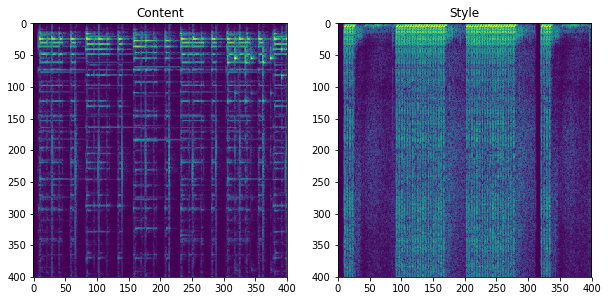

In [10]:
a_content,fs = convert_audio_to_spectogram(CONTENT_FILENAME)
a_style, fs = convert_audio_to_spectogram(STYLE_FILENAME) #rows=(nfft+1)/2, columns=(time_frames - nfft)/(hop_length)+ 5
print("before resizing::", a_style.shape , a_content.shape) 
a_style, a_content = match_shapes(a_content, a_style, N_SAMPLES)
print("after resizing::", a_style.shape , a_content.shape)
N_SAMPLES = a_style.shape[1]
plot_spectogram([{"name":"Content","data": a_content},{"name":"Style","data": a_style}])

## Neural Net 

In [16]:
a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])#1x1x1025x400
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is [filter_height, filter_width, in_channels, out_channels]
std_1 = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS_1) * FILTER_WIDTH_1))
std_2 = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS_2) * FILTER_WIDTH_2))
filter1 = np.random.randn(1, FILTER_WIDTH_1, N_CHANNELS, N_FILTERS_1)*std_1
filter2 = np.random.randn(1, FILTER_WIDTH_2, N_FILTERS_1, N_FILTERS_2)*std_2

g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:

    filter_tf_1 = tf.constant(filter1, name="filter1", dtype='float32')
    filter_tf_2 = tf.constant(filter2, name="filter2", dtype='float32')
    
    # data shape is "[batch, in_height, in_width, in_channels]",
    x_CS = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x_CS")
    conv_CS_1 = tf.nn.conv2d(x_CS, filter_tf_1,strides=[1, 1, 1, 1], padding="VALID", name="conv_CS_1")
    net_CS_1 = tf.nn.relu(conv_CS_1)
    conv_CS_2 = tf.nn.conv2d(net_CS_1, filter_tf_2, strides=[1, 1, 1, 1], padding="VALID", name="conv_CS_2")
    net_CS_2 = tf.nn.relu(conv_CS_2)

    #extracting content
    content_features = net_CS_2.eval(feed_dict={x_CS: a_content_tf})
    print('content shape', content_features.shape)
    
    #extracting style
    style_features = net_CS_2.eval(feed_dict={x_CS: a_style_tf})
    features = np.reshape(style_features, (-1, N_FILTERS_2))
    style_gram = np.matmul(features.T, features) / N_SAMPLES
    print('style shape', style_gram.shape)

with tf.Graph().as_default():
    filter_tf_1 = tf.constant(filter1, name="filter1", dtype='float32')
    filter_tf_2 = tf.constant(filter2, name="filter2", dtype='float32')
    
    # variable input
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")
    conv_1 = tf.nn.conv2d(x,filter_tf_1,strides=[1, 1, 1, 1],padding="VALID",name="conv")
    net_1 = tf.nn.relu(conv_1)
    conv_2 = tf.nn.conv2d(net_1,filter_tf_2,strides=[1, 1, 1, 1],padding="VALID",name="conv")
    net_2 = tf.nn.relu(conv_2)
    
    #optimize
    result = None
    interim_result = None
    
    ##content loss
    content_loss = 2 * tf.nn.l2_loss(net_2 - content_features)
    
    ##style loss
    _, height, width, number = map(lambda i: i.value, net_2.get_shape())
    size = height * width * number
    feats = tf.reshape(net_2, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

    ## Overall loss
    loss = ALPHA*content_loss + BETA*style_loss
        
    ##Optimization   
    opt = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B', options={'maxiter': iterations})    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Started optimization:')
        for i in range(EPOCHS):
            opt.minimize(sess)
            print('i:' , i , 'Interim loss:', loss.eval())
            interim_result = x.eval()
            #step_handler_callback(interim_result, i)
                
    ## result
        print ('Final loss:', loss.eval())
        result = x.eval()
        print('Final result:', result)   

content shape (1, 1, 380, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 14164.226562
  Number of iterations: 50
  Number of functions evaluations: 65
i: 0 Interim loss: 14164.227
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 9111.652344
  Number of iterations: 50
  Number of functions evaluations: 53
i: 1 Interim loss: 9111.652
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 8036.927734
  Number of iterations: 50
  Number of functions evaluations: 53
i: 2 Interim loss: 8036.9277
Final loss: 8036.9277
Final result: [[[[ 0.12757795  0.07780933 -0.23510028 ...  0.19192594  0.11963145
    -0.28142768]
   [ 0.0428802   0.233833    0.26755032 ... -0.42257243 -0.21880297
    -0.40855834]
 

## Invert spectrogram and save the result

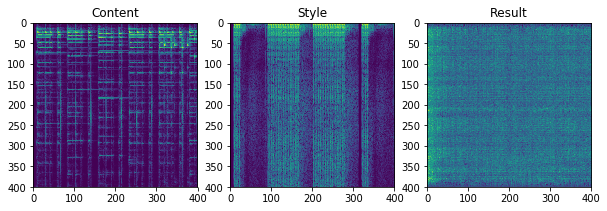

In [17]:
step_handler_callback(result, EPOCHS-1, output_path = OUTPUT_FILENAME)